# Rozpoznawanie ręcznie pisanych cyfr za pomocą PyTorch

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

Pracę rozpoczniemy od pobrania zbioru MNIST, zawierającego 70 tyś. przykładów ręcznie pisanych cyfr 0-9 w formie obrazków 28x28 pikseli. Wykorzystamy w tym celu funkcję `fetch_openml`, która pobera dane z serwisu [https://www.openml.org/](www.openml.org).

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [10]:
X = torch.tensor(mnist.data, dtype=torch.float)
y = torch.tensor([int(v) for v in mnist.target])

Poniższy kod dzieli losow dane na zbiory: uczący, walidujący i testowy w proporcji 70%/10%/20%. Wykorzystaj tak podzielone dane w dalszych krokach. Tym razem zamiast reprezentować te zbiory w postaci "surowych" tensorów, opakowujemy je w obiekt klasy `torch.utils.data.TensorDataset`, który umożliwi później łatwe losowe mieszanie, grupowanie w batches i iterowanie po nich za pomocą `torch.utils.data.DatasetLoader`

In [11]:
n, p = mnist.data.shape
k = 10 # liczba klas
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
train_indices = indices[:n_train]
validation_indices = indices[n_train:n_train+n_validation]
test_indices = indices[n_train+n_validation:]

ds_train = data.TensorDataset(X[train_indices,:], y[train_indices])
ds_validation = data.TensorDataset(X[validation_indices,:], y[validation_indices])
ds_test = data.TensorDataset(X[test_indices,:], y[test_indices])

## Regresja logitstyczna

Stworzymy prosty model regresji logistycznej, uczony na surowych pikselach obrazków. Macierz wag  cech (tutaj: pikseli obrazu) będzie typu $p\times k$ (tzn. $p$ wag dla każdej z $k$ klas). Model będzie obliczał logits, tzn. wyjście regresji logitstycznej **przed** zastosowaniem funkcji softmax: każdy wiersz odpowiada jednemu przykładowi dla zadanego X, a każda kolumna jednej z klas. Gdyby każdy z wierszy unormować funkcją softmax, to w kolejnych wierszach byłyby prawdopodobieństwa, że obiekt należy do danej klasy.

In [47]:
model = nn.Linear(p, k)

Jako miarę do optymalizacji będziemy wykorzystywali *cross entropy*, a optymalizacji będziemy dokonywali za pomocą optymalizatora Adam.

In [48]:
cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

Przygotowujemy funkcję pomocniczą do liczenia trafności klasyfikacji. W każdym wierszu `logits` wybieramy numer kolumny z największą wartością, porównujemy z wartością oczekiwaną i tak uzyskane wartości (0 lub 1) uśredniamy w celu uzyskania trafności klasyfikacji.

In [49]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

Dalej jest już tak samo jak przy regresji liniowej: tworzymy operator do inicjalizacji zmiennych i obiekt sesji, inicjalizujemy zmienne i przez `n_epoch` trenujemy na batchach rozmiaru `batch_size`, zbierając wartości *loss* i *accuracy* na zbiorze uczącym. Upraszczamy podział na *mini batches* przez zlecenie tego zadania klasie `torch.utils.data.DataLoader`

In [44]:
loss_values = []
acc_values = []
batch_size = 100
n_epoch = 100

In [45]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)    
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    model.eval()
    loss_values.append(torch.tensor(epoch_loss).mean())
    logits = model(ds_validation.tensors[0])
    acc = compute_acc(logits, ds_validation.tensors[1])
    acc_values.append(acc)

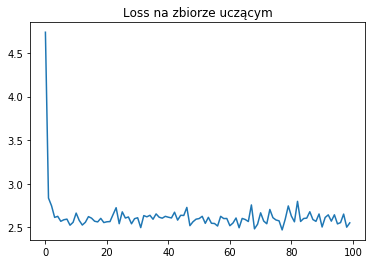

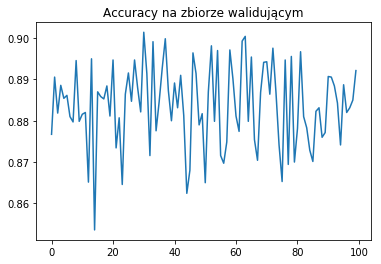

tensor(0.8921)


In [46]:
plt.title("Loss na zbiorze uczącym")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy na zbiorze walidującym")
plt.plot(acc_values)
plt.show()

## Early stopping

Zadanie do samodzielnego wykonania: wykorzystaj powyższy kod i zaimplementuj *early stopping* zamiast trenowania przez stałą liczbę epok.

In [ ]:
# Tu kod, może być w więcej niż jednej komórce

## Sieć neuronowa z jedną warstwą ukrytą

Regresja logistyczna to wariant sieci neuronowej bez warstw ukrytych. Wykorzystaj powyższy kod i rozszerz go o warstwę ukrytą o h=500 neuronach. Żeby połączyć kilka obiektów typu `torch.nn.Module` w sekwencję wykorzystaj klasę `torch.nn.Sequence`. Do implementacji nieliniowości między warstwami wykorzystaj funkcję LeakyReLU implementowaną przez klasę `torch.nn.LeakyReLU`

Zaimplementuj early stopping. W trakcie uczenia zbieraj wartości straty i accuracy na zbiorze uczącym i na zbiorze walidującym, a następnie narysuj je na wykresach. Jeżeli uczenie trwa zbyt wolno jak na Twój gust, zmniejsz `batch_size` i/lub liczbę neuronów w warstwie ukrytej.

In [50]:
# Tu kod, może być w więcej niż jednej komórce